In [1]:
# Fetch COPOM statements from BCB API
import pandas as pd
import html
import re
from bs4 import BeautifulSoup

def fetch_copom_comunicado(meeting_number):
    """Fetch and clean COPOM statement for a given meeting number."""
    def clean_html(raw_html):
        if not raw_html:
            return ""
        decoded = html.unescape(raw_html)
        decoded = re.sub(r'[\u200b\ufeff\u00a0]', '', decoded)
        soup = BeautifulSoup(decoded, 'html.parser')
        
        # Remove tables
        for table in soup.find_all('table'):
            table.decompose()
        
        for br in soup.find_all('br'):
            br.replace_with('\n')
        for p in soup.find_all('p'):
            p.insert_after('\n\n')
        
        text = soup.get_text()
        text = re.sub(r'\n\s*\n', '\n\n', text)
        text = re.sub(r'[ \t]+', ' ', text)
        return text.strip()
    
    url = f"https://www.bcb.gov.br/api/servico/sitebcb/copom/comunicados_detalhes?nro_reuniao={meeting_number}"
    df = pd.read_json(url)
    content = df.iloc[0].iloc[0]
    
    return {
        "meeting": content.get('nro_reuniao'),
        "date": content.get('dataReferencia'),
        "title": content.get('titulo'),
        "text_pt": clean_html(content.get('textoComunicado'))
    }

# Fetch recent COPOM statements (e.g., meetings 260-274)
meetings = range(260, 275)
data = []

print("Fetching COPOM statements...")
for m in meetings:
    try:
        stmt = fetch_copom_comunicado(m)
        data.append(stmt)
        print(f"  Meeting {m}: {stmt['date'][:10] if stmt['date'] else 'N/A'}")
    except Exception as e:
        print(f"  Meeting {m}: Error - {e}")

print(f"\nLoaded {len(data)} statements")
data[:2]  # Preview first two

Fetching COPOM statements...
  Meeting 260: 2024-01-31
  Meeting 261: 2024-03-20
  Meeting 262: 2024-05-08
  Meeting 263: 2024-06-19
  Meeting 264: 2024-07-31
  Meeting 265: 2024-09-18
  Meeting 266: 2024-11-06
  Meeting 267: 2024-12-11
  Meeting 268: 2025-01-29
  Meeting 269: 2025-03-19
  Meeting 270: 2025-05-07
  Meeting 271: 2025-06-18
  Meeting 272: 2025-07-30
  Meeting 273: 2025-09-17
  Meeting 274: 2025-11-05

Loaded 15 statements


[{'meeting': 260,
  'date': '2024-01-31',
  'title': 'Copom reduz a taxa Selic para 11,25% a.a.',
  'text_pt': 'O ambiente externo segue volátil, marcado pelo debate sobre o início da flexibilização de política monetária nas principais economias e por sinais de queda dos núcleos de inflação, que ainda permanecem em níveis elevados em diversos países. Os bancos centrais das principais economias permanecem determinados em promover a convergência das taxas de inflação para suas metas em um ambiente marcado por pressões nos mercados de trabalho. O Comitê avalia que o cenário segue exigindo cautela por parte de países emergentes.\n\nEm relação ao cenário doméstico, o conjunto dos indicadores de atividade econômica segue consistente com o cenário de desaceleração da economia antecipado pelo Copom. A inflação cheia ao consumidor, conforme esperado, manteve trajetória de desinflação, assim como as medidas de inflação subjacente, que se aproximam da meta para a inflação nas divulgações mais rec

In [2]:
# 0) data: list[{"meeting": 274, "date":"2024-03-20", "text_pt": "..."}]

import numpy as np
import spacy
from sentence_transformers import SentenceTransformer, util
from scipy.signal import find_peaks

nlp = spacy.load("pt_core_news_md")  # or en_core_web_md if needed
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # swap to FinBERT/SBERT-pt if available

def to_sentences(txt):
    return [s.text.strip() for s in nlp(txt).sents if s.text.strip()]

def rolling_divergence(emb, k_base=20, k_local=5):
    N = len(emb)
    div = np.zeros(N)
    for i in range(N):
        base_start = max(0, i - k_base)
        base_vecs = emb[base_start:i] if i>0 else emb[0:1]
        sim = util.cos_sim(emb[i], base_vecs).mean().item()
        div[i] = 1 - sim
    return div

def process_statement(text):
    sents = to_sentences(text)
    emb = model.encode(sents, normalize_embeddings=True)
    div = rolling_divergence(emb, k_base=20)
    peaks, _ = find_peaks(div, prominence=0.08)  # tune
    return sents, div, peaks


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
# Process first statement as example
sents, div, peaks = process_statement(data[0]["text_pt"])
print(f"Meeting {data[0]['meeting']} - {len(sents)} sentences")
print(f"Peak divergence indices: {peaks}")

Meeting 260 - 25 sentences
Peak divergence indices: [2 5]


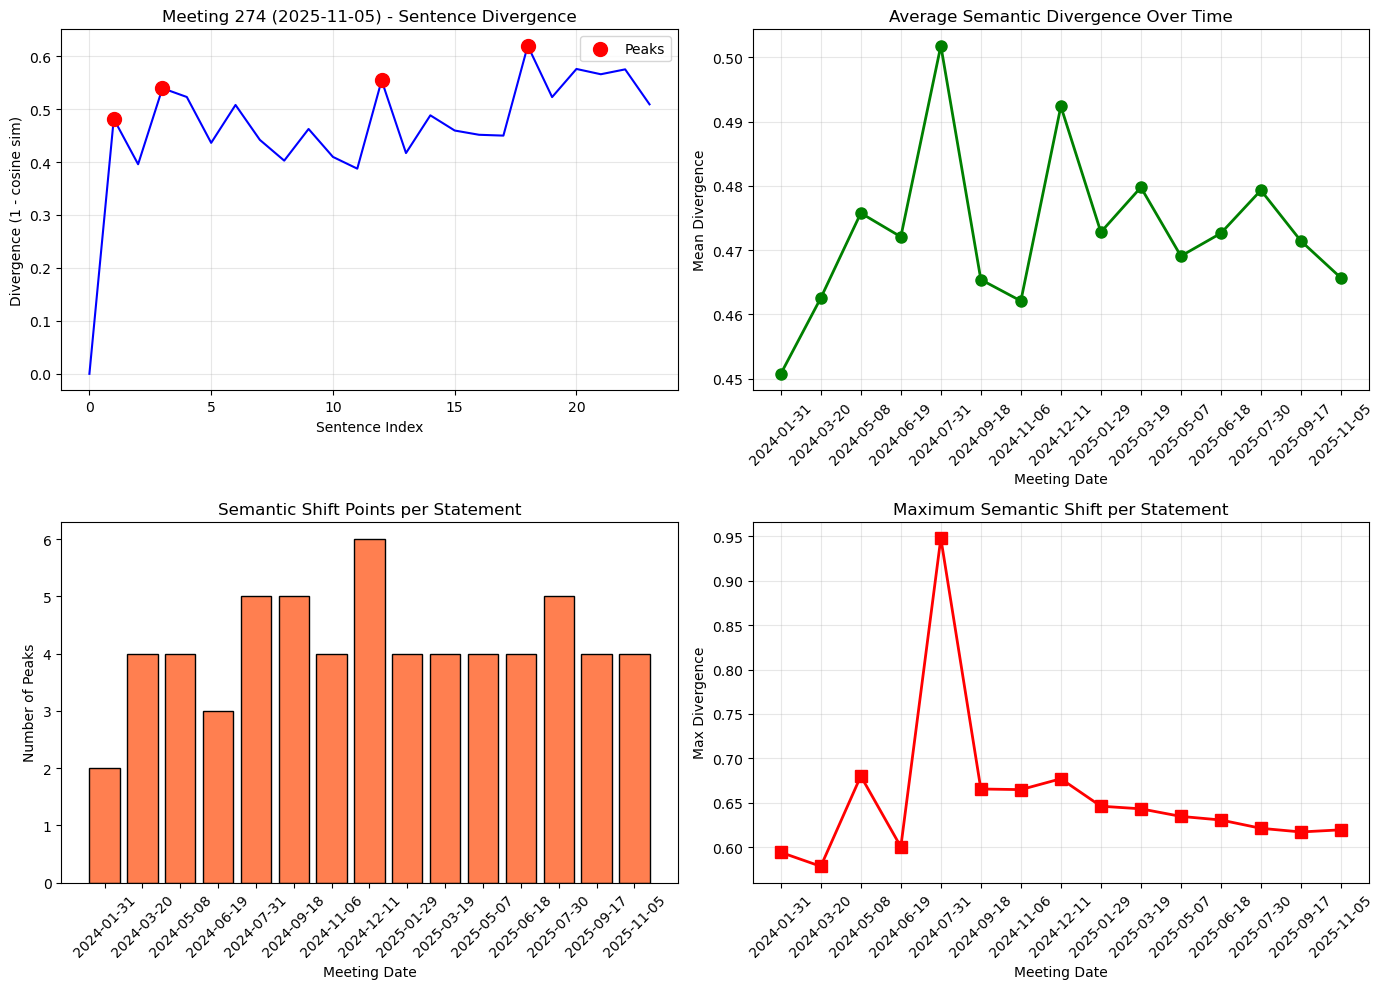


=== Key Sentences at Divergence Peaks (Meeting 274) ===

[Sentence 1] (div=0.481)
  Tal cenário exige particular cautela por parte de países emergentes em ambiente marcado por tensão geopolítica....

[Sentence 3] (div=0.539)
  Nas divulgações mais recentes, a inflação cheia e as medidas subjacentes apresentaram algum arrefecimento, mas mantiveram-se acima da meta para a inflação....

[Sentence 12] (div=0.554)
  O Copom decidiu manter a taxa básica de juros em 15,00% a.a....

[Sentence 18] (div=0.620)
  Votaram por essa decisão os seguintes membros do Comitê: Gabriel Muricca Galípolo (presidente), Ailton de Aquino Santos, Diogo Abry Guillen, Gilneu Francisco Astolfi Vivan, Izabela Moreira Correa, Nil...



In [4]:
import matplotlib.pyplot as plt

# Process all statements and collect results
results = []
for stmt in data:
    sents, div, peaks = process_statement(stmt["text_pt"])
    results.append({
        "meeting": stmt["meeting"],
        "date": stmt["date"][:10],
        "n_sentences": len(sents),
        "sentences": sents,
        "divergence": div,
        "peaks": peaks,
        "mean_div": np.mean(div),
        "max_div": np.max(div)
    })

# 1) Plot divergence over sentences for a single meeting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pick a meeting to analyze in detail
idx = -1  # Latest meeting
r = results[idx]

# Divergence curve
ax1 = axes[0, 0]
ax1.plot(r["divergence"], 'b-', lw=1.5)
ax1.scatter(r["peaks"], r["divergence"][r["peaks"]], c='red', s=100, zorder=5, label='Peaks')
ax1.set_xlabel("Sentence Index")
ax1.set_ylabel("Divergence (1 - cosine sim)")
ax1.set_title(f"Meeting {r['meeting']} ({r['date']}) - Sentence Divergence")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2) Mean divergence across meetings (policy shift indicator)
ax2 = axes[0, 1]
dates = [r["date"] for r in results]
mean_divs = [r["mean_div"] for r in results]
ax2.plot(dates, mean_divs, 'go-', lw=2, markersize=8)
ax2.set_xlabel("Meeting Date")
ax2.set_ylabel("Mean Divergence")
ax2.set_title("Average Semantic Divergence Over Time")
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3) Number of peaks per meeting (complexity/novelty indicator)
ax3 = axes[1, 0]
n_peaks = [len(r["peaks"]) for r in results]
ax3.bar(dates, n_peaks, color='coral', edgecolor='black')
ax3.set_xlabel("Meeting Date")
ax3.set_ylabel("Number of Peaks")
ax3.set_title("Semantic Shift Points per Statement")
ax3.tick_params(axis='x', rotation=45)

# 4) Max divergence (biggest single shift)
ax4 = axes[1, 1]
max_divs = [r["max_div"] for r in results]
ax4.plot(dates, max_divs, 'rs-', lw=2, markersize=8)
ax4.set_xlabel("Meeting Date")
ax4.set_ylabel("Max Divergence")
ax4.set_title("Maximum Semantic Shift per Statement")
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show high-divergence sentences (potential policy shifts)
print(f"\n=== Key Sentences at Divergence Peaks (Meeting {r['meeting']}) ===\n")
for p in r["peaks"][:5]:  # Top 5 peaks
    print(f"[Sentence {p}] (div={r['divergence'][p]:.3f})")
    print(f"  {r['sentences'][p][:200]}...")
    print()

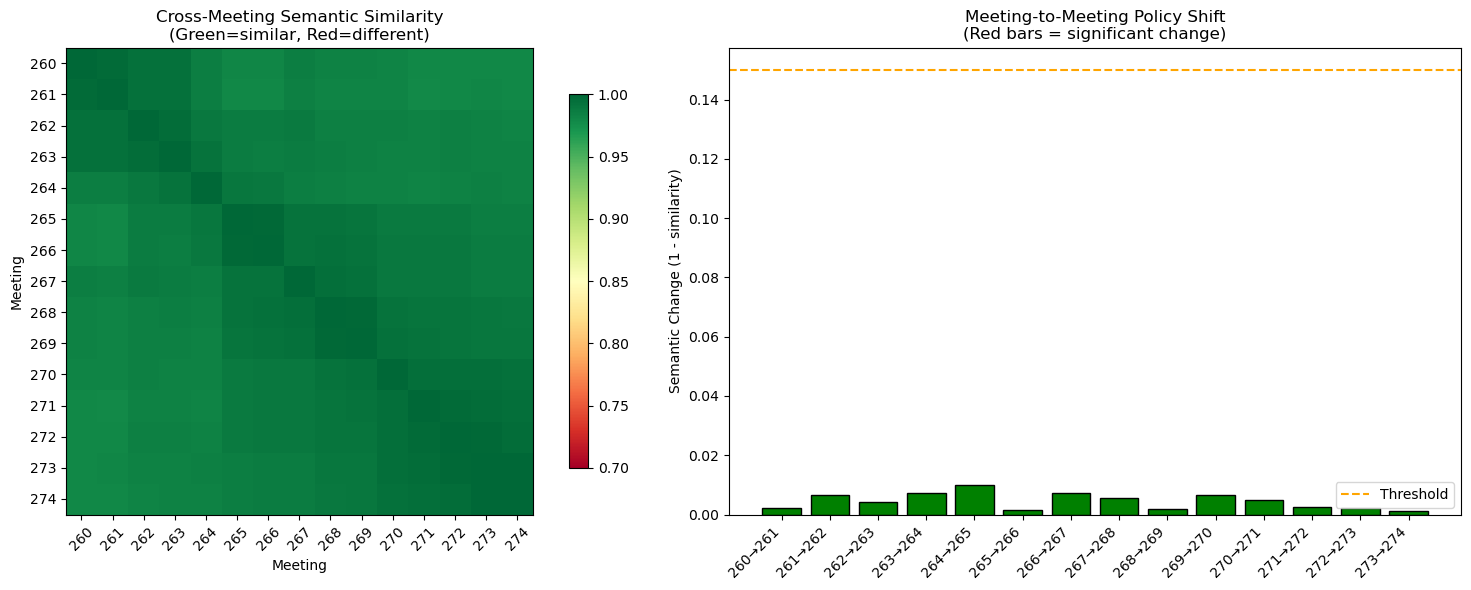


=== Biggest Policy Shifts Between Consecutive Meetings ===
  264→265: 0.010 change
  263→264: 0.007 change
  266→267: 0.007 change
  269→270: 0.007 change
  261→262: 0.006 change


In [5]:
# === 1) Cross-meeting similarity heatmap (policy continuity) ===
from sklearn.metrics.pairwise import cosine_similarity

# Get document-level embeddings (mean of sentence embeddings)
doc_embeddings = []
for stmt in data:
    sents = to_sentences(stmt["text_pt"])
    emb = model.encode(sents, normalize_embeddings=True)
    doc_embeddings.append(emb.mean(axis=0))

doc_embeddings = np.array(doc_embeddings)
sim_matrix = cosine_similarity(doc_embeddings)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
ax = axes[0]
im = ax.imshow(sim_matrix, cmap='RdYlGn', vmin=0.7, vmax=1.0)
ax.set_xticks(range(len(data)))
ax.set_yticks(range(len(data)))
ax.set_xticklabels([d["meeting"] for d in data], rotation=45)
ax.set_yticklabels([d["meeting"] for d in data])
ax.set_title("Cross-Meeting Semantic Similarity\n(Green=similar, Red=different)")
ax.set_xlabel("Meeting")
ax.set_ylabel("Meeting")
plt.colorbar(im, ax=ax, shrink=0.8)

# === 2) Meeting-to-meeting change (sequential diff) ===
ax2 = axes[1]
sequential_sim = [sim_matrix[i, i+1] for i in range(len(data)-1)]
sequential_change = [1 - s for s in sequential_sim]
meeting_pairs = [f"{data[i]['meeting']}→{data[i+1]['meeting']}" for i in range(len(data)-1)]

colors = ['red' if c > 0.15 else 'green' for c in sequential_change]
ax2.bar(range(len(sequential_change)), sequential_change, color=colors, edgecolor='black')
ax2.set_xticks(range(len(sequential_change)))
ax2.set_xticklabels(meeting_pairs, rotation=45, ha='right')
ax2.set_ylabel("Semantic Change (1 - similarity)")
ax2.set_title("Meeting-to-Meeting Policy Shift\n(Red bars = significant change)")
ax2.axhline(y=0.15, color='orange', linestyle='--', label='Threshold')
ax2.legend()

plt.tight_layout()
plt.show()

# Identify biggest policy shifts
print("\n=== Biggest Policy Shifts Between Consecutive Meetings ===")
shifts = sorted(zip(meeting_pairs, sequential_change), key=lambda x: -x[1])
for pair, change in shifts[:5]:
    print(f"  {pair}: {change:.3f} change")

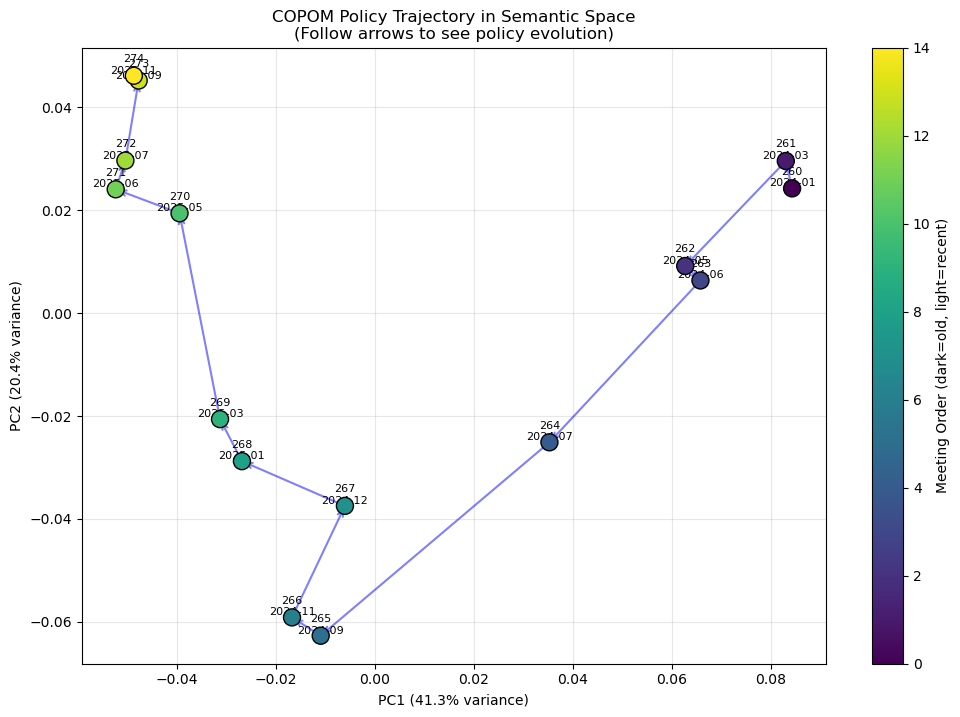

In [6]:
# === 3) PCA trajectory of policy stance ===
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
coords = pca.fit_transform(doc_embeddings)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot trajectory with arrows
for i in range(len(coords)-1):
    ax.annotate('', xy=coords[i+1], xytext=coords[i],
                arrowprops=dict(arrowstyle='->', color='blue', alpha=0.5, lw=1.5))

# Scatter points colored by time
scatter = ax.scatter(coords[:, 0], coords[:, 1], 
                     c=range(len(coords)), cmap='viridis', s=150, zorder=5, edgecolors='black')

# Label each point
for i, d in enumerate(data):
    ax.annotate(f"{d['meeting']}\n{d['date'][:7]}", 
                (coords[i, 0], coords[i, 1]), 
                fontsize=8, ha='center', va='bottom')

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
ax.set_title("COPOM Policy Trajectory in Semantic Space\n(Follow arrows to see policy evolution)")
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Meeting Order (dark=old, light=recent)')
plt.show()

=== Most Common Terms at Policy Shift Points (All Meetings) ===

  inflação: 21
  comitê: 20
  cenário: 16
  país: 16
  política: 15
  exigir: 14
  cautela: 14
  avaliar: 13
  parte: 13
  emergente: 13
  seguir: 11
  expectativa: 10
  apurar: 10
  pesquisa: 10
  recente: 7
  externo: 6
  encontrar se: 5
  torno: 5
  monetário: 5
  marcar: 5


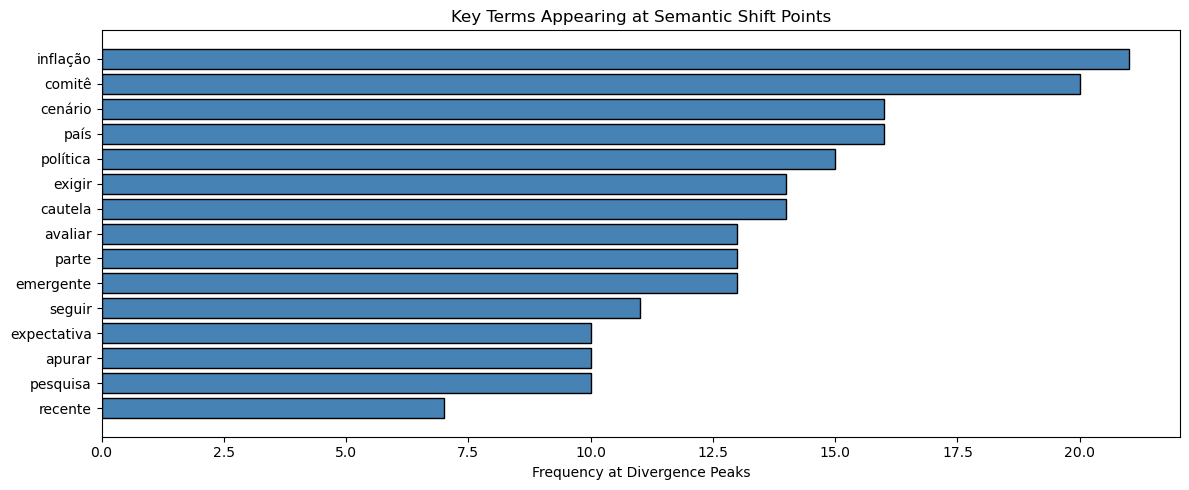

In [7]:
# === 4) Keyword/Topic extraction at divergence peaks ===
from collections import Counter

def extract_keywords(sentences, peaks, top_n=10):
    """Extract most common nouns/verbs at peak divergence points"""
    peak_tokens = []
    for p in peaks:
        if p < len(sentences):
            doc = nlp(sentences[p])
            for token in doc:
                if token.pos_ in ['NOUN', 'VERB', 'ADJ'] and len(token.text) > 3:
                    peak_tokens.append(token.lemma_.lower())
    return Counter(peak_tokens).most_common(top_n)

# Aggregate keywords from all meetings' peaks
all_peak_keywords = Counter()
for r in results:
    kw = extract_keywords(r["sentences"], r["peaks"], top_n=20)
    all_peak_keywords.update(dict(kw))

print("=== Most Common Terms at Policy Shift Points (All Meetings) ===\n")
for word, count in all_peak_keywords.most_common(20):
    print(f"  {word}: {count}")

# Plot keyword frequency
fig, ax = plt.subplots(figsize=(12, 5))
top_words = all_peak_keywords.most_common(15)
words, counts = zip(*top_words)
ax.barh(words[::-1], counts[::-1], color='steelblue', edgecolor='black')
ax.set_xlabel("Frequency at Divergence Peaks")
ax.set_title("Key Terms Appearing at Semantic Shift Points")
plt.tight_layout()
plt.show()

In [8]:
# === 5) Compare specific meetings side-by-side ===
def compare_meetings(m1_idx, m2_idx):
    """Compare two meetings to find what changed"""
    r1, r2 = results[m1_idx], results[m2_idx]
    
    # Get sentence embeddings
    emb1 = model.encode(r1["sentences"], normalize_embeddings=True)
    emb2 = model.encode(r2["sentences"], normalize_embedings=True)
    
    # Find sentences in m2 most different from all of m1 (new content)
    new_content = []
    for i, s2 in enumerate(r2["sentences"]):
        max_sim = util.cos_sim(emb2[i], emb1).max().item()
        new_content.append((1 - max_sim, i, s2))
    
    new_content.sort(reverse=True)
    
    print(f"=== New Content in Meeting {r2['meeting']} vs {r1['meeting']} ===\n")
    for diff, idx, sent in new_content[:5]:
        print(f"[Novelty: {diff:.3f}] {sent[:150]}...")
        print()

# Compare last two meetings
compare_meetings(-2, -1)

=== New Content in Meeting 274 vs 273 ===

[Novelty: 0.130] O ambiente externo ainda se mantém incerto em função da conjuntura e da política econômica nos Estados Unidos, com reflexos nas condições financeiras ...

[Novelty: 0.084] O Comitê enfatiza que seguirá vigilante, que os passos futuros da política monetária poderão ser ajustados e que não hesitará em retomar o ciclo de aj...

[Novelty: 0.080] O Comitê avalia que a estratégia de manutenção do nível corrente da taxa de juros por período bastante prolongado é suficiente para assegurar a conver...

[Novelty: 0.072] Além disso, adota-se a hipótese de bandeira tarifária “amarela" em dezembro de 2025 e de 2026....

[Novelty: 0.043] Em relação ao cenário doméstico, o conjunto dos indicadores segue apresentando, conforme esperado, trajetória de moderação no crescimento da atividade...

